In [1]:
%precision %.2f
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import date
from IPython.display import display

import src.compute.timeline as timeline
import src.compute.developer as developer
from src.compute.utils import Interval
from src.db.utils import SnowflakeWrapper

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
conn = SnowflakeWrapper.create_snowflake_connection()
sw = SnowflakeWrapper(conn)
figure_size = (14, 12)


In [2]:
active_interval: Interval = Interval(
    # fromDate=date(2019, 7, 1), # year, month, day
    # toDate=date(2019, 10, 1),
    fromDate=date(2019, 10, 1), # year, month, day
    toDate=date(2020, 1, 1)
)
print(active_interval)

('2019-10-01', '2020-01-01')


In [3]:
res = timeline.get_avg_timeline(sw, active_interval)
# display(res)

SELECT     STATUS                          "Status",     COUNT(DISTINCT KEY)             "UniqueIssues",     COUNT(*)                        "Issues",     "Issues" - "UniqueIssues"       "Reassignments",     AVG(TIMEDELTA) / (60 * 60 * 24) "AvgDays",     MAX(TIMEDELTA) / (60 * 60 * 24) "MaxDays",     MIN(TIMEDELTA) / (60 * 60 * 24) "MinDays" FROM TIMELINES t WHERE     t.DATEFROM >= '2019-10-01'     AND t.DATETO < '2020-01-01' GROUP BY 1 ORDER BY 1, 4 DESC; 


In [4]:
avg_dev = developer.get_avg_developer(sw, active_interval)
# display(avg_dev)

Note: These values are high because of ongoing events.


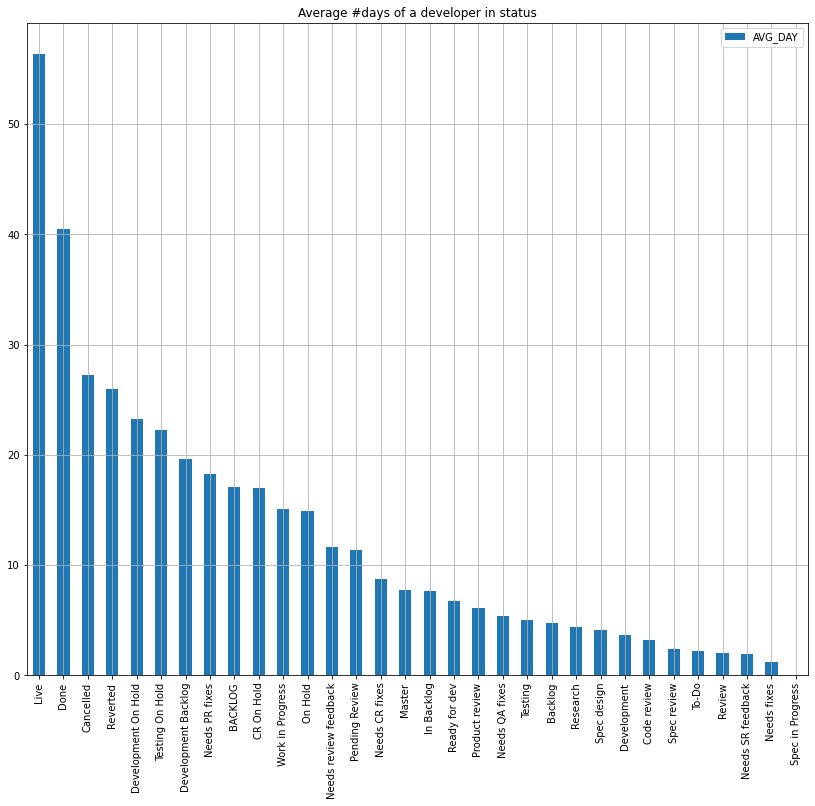

In [5]:
print("Note: These values are high because of ongoing events.")
avg_dev.loc[avg_dev["AVG_DAY"] > 0].sort_values("AVG_DAY", ascending=False).plot(kind='bar', use_index=True, y='AVG_DAY', figsize=figure_size, grid=True, title="Average #days of a developer in status")

Spec in progress = 0.009 days


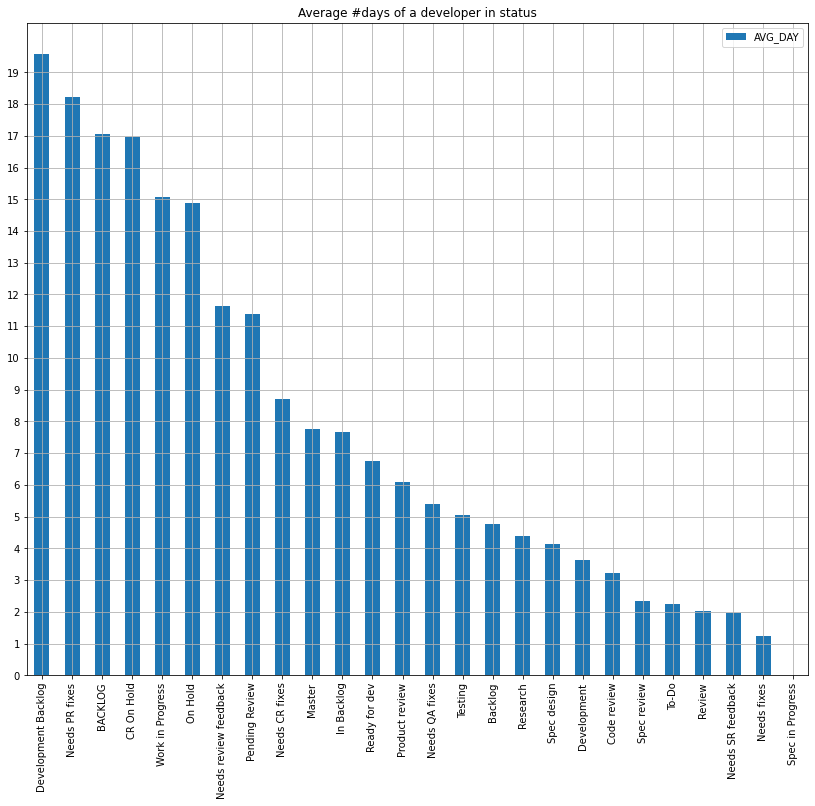

In [6]:
print("Spec in progress = 0.009 days")
avg_dev.loc[(avg_dev["AVG_DAY"] > 0) & (avg_dev["AVG_DAY"] < 20)]\
    .sort_values("AVG_DAY", ascending=False)\
    .plot(
        kind='bar', 
        use_index=True, 
        y='AVG_DAY', 
        figsize=figure_size, 
        grid=True,
        yticks=range(0, 20, 1),
        title="Average #days of a developer in status"
    )

In [7]:
# avg_dev_merged = developer.get_avg_developer(sw, active_interval,merge=True)
# print("Not a good idea to merge the statuses because some statuses are obsolete, and cause noise in the data:")
# display(avg_dev_merged)

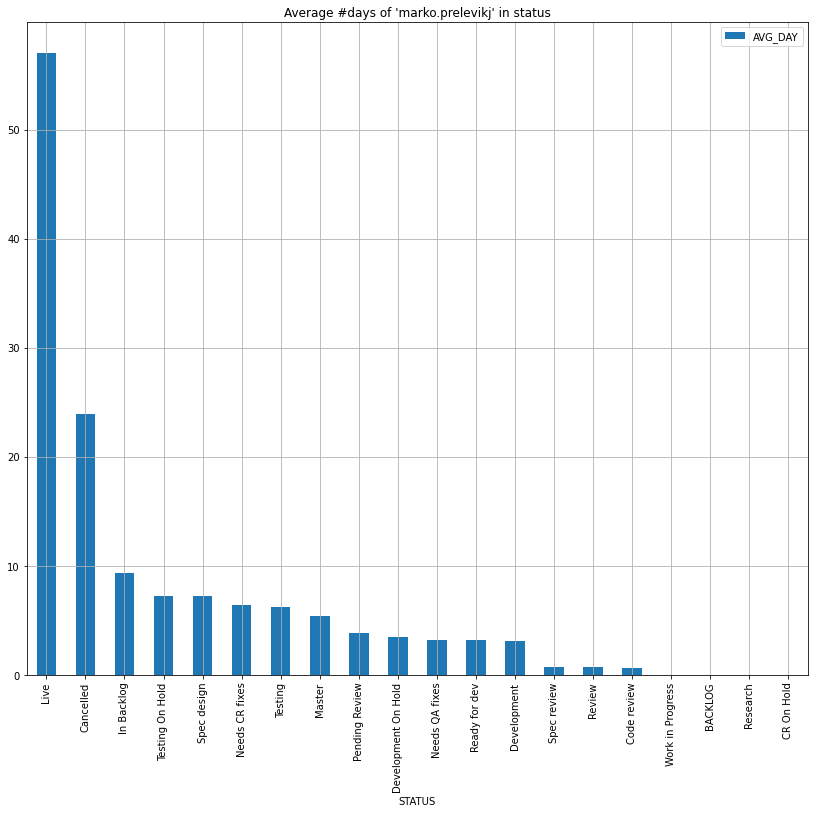

In [8]:
userId = "marko.prelevikj"
dev = developer.get_developer(sw, interval=active_interval, userId=userId)
dev.loc[(dev["AVG_DAY"] > 0)]\
    .sort_values("AVG_DAY", ascending=False)\
    .plot(
        kind='bar', 
        x="STATUS",
        y="AVG_DAY", 
        figsize=figure_size, 
        grid=True,
        # yticks=range(0, int(dev["AVG_DAY"].max()) + 1, 1),
        title=f"Average #days of '{userId}' in status"
    )

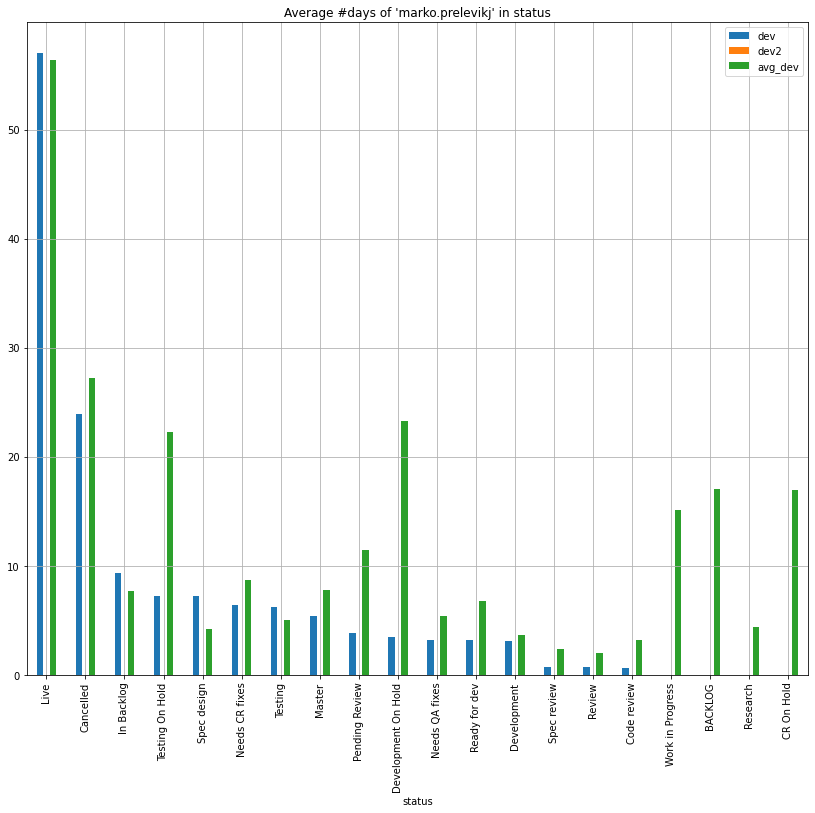

In [9]:
dev2 = developer.get_developer(sw, interval=active_interval, userId="<PII>")
avg_dev_by_status = avg_dev.sort_values("STATUS")
dev_by_status = dev.set_index("STATUS")
dev2_by_status = dev2.set_index("STATUS")
dev_by_status = dev_by_status.sort_values("STATUS")
dev2_by_status = dev2_by_status.sort_values("STATUS")

combined = pd.concat(
    [
        avg_dev_by_status["STATUS"].rename("status"), 
        avg_dev_by_status["AVG_DAY"].rename("avg_dev"), 
        dev_by_status["AVG_DAY"].rename("dev"),
        dev2_by_status["AVG_DAY"].rename("dev2")
    ],
    axis=1,
    sort=False
).fillna(0)

combined.loc[(combined["dev"] > 0)]\
    .sort_values("dev", ascending=False)\
    .plot(
        kind='bar', 
        x="status",
        y=["dev", "dev2", "avg_dev"], 
        figsize=figure_size, 
        grid=True,
        # yticks=range(0, int(dev["AVG_DAY"].max()) + 1, 1),
        title=f"Average #days of '{userId}' in status"
    )

In [10]:
intervals = [
    Interval(fromDate=date(2019, 1, 1), toDate=date(2019, 4, 1)),
    Interval(fromDate=date(2019, 4, 1), toDate=date(2019, 7, 1)),
    Interval(fromDate=date(2019, 7, 1), toDate=date(2019, 10, 1)),
    Interval(fromDate=date(2019, 10, 1), toDate=date(2020, 1, 1))
]

In [11]:
avgs = [ developer.get_avg_developer(sw, interval) for interval in intervals ]

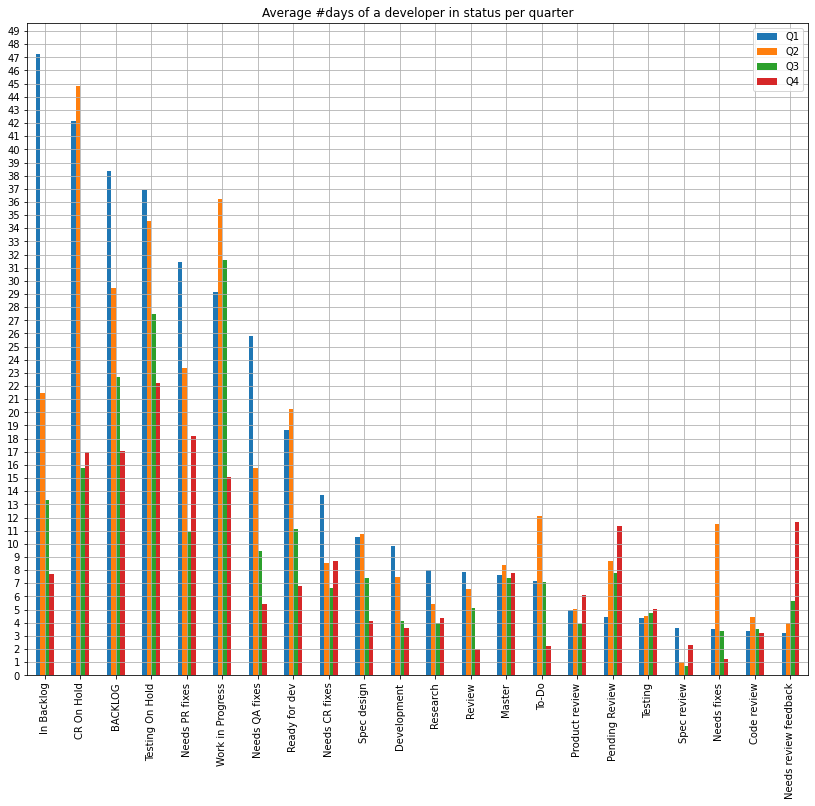

In [38]:
to_view_avg = pd.DataFrame()
for i, x in enumerate(avgs):
    to_view_avg = pd.concat(
        [
            to_view_avg,
            x["AVG_DAY"].rename(f"Q{i + 1}")
        ],
        axis=1,
        sort=False
    )

to_view_avg.loc[(to_view_avg["Q1"] > 0) & (to_view_avg["Q1"] < 50)]\
    .sort_values("Q1", ascending=False)\
    .plot(
        kind='bar', 
        use_index=True, 
        y=["Q1", "Q2", "Q3", "Q4"], 
        figsize=figure_size, 
        grid=True,
        yticks=range(0, 50, 1),
        title="Average #days of a developer in status per quarter"
    )


In [13]:
dev_qs = [developer.get_developer(sw, interval=interval, userId=userId) for interval in intervals]

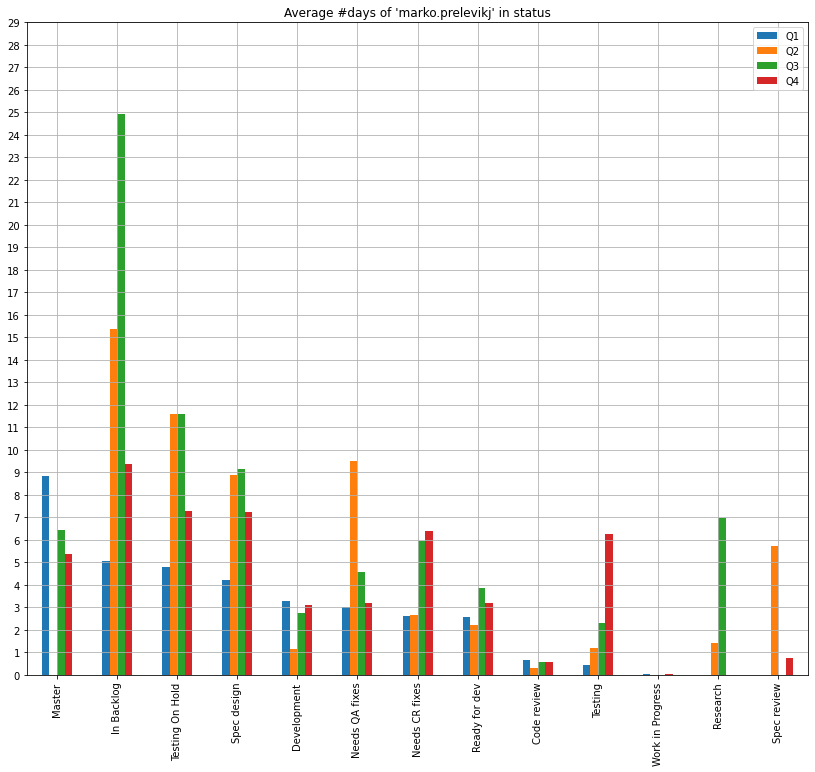

In [29]:
to_view = pd.DataFrame()
for i, x in enumerate(dev_qs):
    dev_q = x.set_index("STATUS")
    dev_q = dev_q.sort_values("STATUS")
    to_view = pd.concat(
        [
            to_view,
            dev_q["AVG_DAY"].rename(f"Q{i + 1}")
        ],
        axis=1,
        sort=False
    )

combined_dev_qs = pd.concat(
    [
        dev_qs[-1]["STATUS"].rename("status"),
        to_view
    ],
    axis=1,
    sort=False
).fillna(0)

combined_dev_qs.loc[(combined_dev_qs["Q1"] > 0) & (combined_dev_qs["Q1"] < 20)]\
    .sort_values("Q1", ascending=False)\
    .plot(
        kind='bar', 
        use_index=True, 
        y=["Q1", "Q2", "Q3", "Q4"], 
        figsize=figure_size, 
        grid=True,
        yticks=range(0, 30, 1),
        title=f"Average #days of '{userId}' in status"
    )